In [1]:
import os 
import re
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

from pathlib import Path
from Bio import SeqIO
from itertools import islice
from tqdm import tqdm
import torch
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, GRU, Bidirectional, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

%cd dataset/

/home/arnaud/miniconda3/envs/projet_long/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-02 05:10:26.611894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/arnaud/projet_long/dataset


# Preprocessing

## Embedding generation

### Core PU Sequence generation

In [2]:
classes = []
topo = []
protofold = []
fq = []
pu = []

with open('../LISTS_CATFS_PU_PROTOTYPE_with_fused_famillies', 'r') as file:
    for line in islice(file, 7, None):
        tmp = line.split(maxsplit=5)
        if len(tmp[2])>=2 and int(tmp[4])>10:
            classes.append(tmp[0])
            topo.append(tmp[2])
            protofold.append(tmp[3])
            fq.append(tmp[4])
            pu.append(tmp[5])

x = {'Class':classes, 'Topology':topo, 'Protofold':protofold, 'Frequency':fq, 'PU':pu}
list_pu = pd.DataFrame(x, columns=['Class', 'Topology', 'Protofold', 'Frequency', 'PU'])
list_pu = list_pu.astype({'Frequency': 'int'})

In [3]:
list_pu

,Class,Topology,Protofold,Frequency,PU
0,Alpha-beta,aUbLa,35.g162,157,1YISA_10_258_288 :3K7XA_10_267_294 4G10A_4_105...
1,Alpha-beta,bUaUbLa,45.g94,31,3ICSA_11_510_555 :2HHGA_2_86_132 3SNKA_1_1_48 ...
2,All-alpha,aUa,30.g155,18,1GTVA_5_94_120 :3HHWK_10_221_247 3CYMA_11_344_...
3,Alpha-beta,aLbUa,40.g195,30,2YGUA_1_1_44 :2QUYA_2_220_260 3NRGA_4_65_113 3...
4,All-beta,bUbUb,40.g161,12,3HBKA_4_141_178 :3HBKA_4_141_178 2V73A_2_96_13...
...,...,...,...,...,...
1170,Alpha-beta,aUb,20.g33,209,2OCZA_4_73_96 :3I4JA_10_62_87 3MDDA_10_66_89 2...
1171,Alpha-beta,aUbLa,30.g84,37,1EV7A_6_179_211 :3SQNA_10_282_316 2ICWG_3_151_...
1172,All-beta,bUbUb,30.g13,91,1EW4A_3_26_53 :3Q7MA_10_123_156 3OBYA_10_110_1...
1173,Alpha-beta,aLbLa,30.g11,200,1OKSA_1_1_30 :3LLKA_5_136_165 3FRKA_10_339_365...


Sort Dataframe by Frequency and
Remove duplicate for Protofold

In [4]:
list_pu = list_pu.sort_values('Frequency', ascending=False)
filt_pu = list_pu.drop_duplicates(subset=['Topology', 'Protofold','Frequency'], keep='first')
filt_pu = filt_pu.reset_index(drop=True)

In [6]:
filt_pu

,Class,Topology,Protofold,Frequency,PU
0,Alpha-beta,bLa,35.g219,1209,1VHOA_7_288_318 :3VHLA_6_236_264 3ONOA_1_142_1...
1,All-alpha,aUa,30.g9,1004,1S9UA_4_157_189 :2RKLA_1_17_53 3G7RA_3_152_182...
2,All-alpha,aUa,35.g0,1004,1CPQA_3_16_49 :3M73A_10_84_118 3PEVB_6_89_128 ...
3,All-alpha,aUa,30.g28,966,1IO1A_5_30_63 :1ZROA_13_488_520 2QX5A_10_353_3...
4,All-alpha,aUa,40.g122,903,2PZIA_10_505_544 :3NCTA_3_1_34 3MZVA_1_272_309...
...,...,...,...,...,...
687,All-beta,bUbLb,35.g133,11,1YFQA_10_270_301 :3F3FA_10_32_63 3VU4A_12_21_5...
688,Alpha-beta,aUbUb,40.g87,11,1C7NA_6_290_331 :2CY8A_10_284_325 3BCHA_2_156_...
689,Alpha-beta,aUbLa,25.g204,11,1KHDA_10_1_25 :2WB7A_10_132_158 2NSZA_3_105_12...
690,Alpha-beta,bUa,30.g156,11,1MOQA_11_51_78 :3SDOA_12_320_347 2AMLA_11_217_...


Generate list of pu without redundancy of pu in a protofold class (for example, 30.g219 and 50.g219 are considered the same so if a pu is present in both class, only the first one will be kept)


In [19]:
df_pu = pd.DataFrame().assign(Protofold = filt_pu.iloc[:300,:]['Protofold'], PU = filt_pu.iloc[:300,:]['PU'])
tmp_df = df_pu['PU'].str.split(' ').apply(pd.Series, 1).stack() #Split PU into rows
tmp_df = tmp_df.replace(r'n','', regex=True).replace(r':','', regex=True) #Remove 'n' and ':'
tmp_df.index = tmp_df.index.droplevel(-1)
tmp_df.name = 'PU' #Need to rename to have index with which joining can be done
del df_pu['PU']
df_pu = df_pu.join(tmp_df)
df_pu['Class'] = df_pu['Protofold'].str.split('.', expand = True)[1] #Get ID : 35.g129 -> g219
df_pu = df_pu.drop_duplicates(subset=['PU', 'Class'], keep='first')
df_pu

,Protofold,PU,Class
0,35.g219,1VHOA_7_288_318,g219
0,35.g219,3VHLA_6_236_264,g219
0,35.g219,3ONOA_1_142_167,g219
0,35.g219,3U52A_5_51_82,g219
0,35.g219,3T92A_1_86_112,g219
...,...,...,...
299,20.g92,3M0ZA_7_179_194,g92
299,20.g92,2VHJA_10_207_222,g92
299,20.g92,3ROTA_11_150_165,g92
299,20.g92,1W94A_5_19_34,g92


In [6]:
select_pu, unique_pu = [], []
select_pu = df_pu[['Protofold', 'PU']].values.tolist()
[unique_pu.append([proto, pu]) for proto, pu in select_pu if pu not in [item[1] for item in unique_pu]]
print(f"There are {len(select_pu)} total PU and {len(unique_pu)} unique")

There are 45100 total PU and 18765 unique


### Generate Core PU Embedding with ESMFold2

Generate PU for aligning and getting source sequence. Embedding will be done on unique_pu first as some of their source sequences are shared with select_pu

In [ ]:
def pdb_gen(file):
    with open(tmp.txt) as file:
      f = file.read()
      pdb = re.search(r">>\w{4}_.", f).group(0)[2:]
      pos = re.findall(r"\d+-\d+", f)[1]
      yield pdb, pos

In [ ]:
no_result = []

for proto, pu in tqdm(islice(unique_pu, len(unique_pu))):
  name = f'{pu[0:4].lower()}_{pu[4]}'
  !ssearch36 ./PU/$pu.fasta ./pdb_seqres.txt | grep -A2 -m1 ^>>$name > ./tmp.txt
  
  if os.stat(tmp.txt).st_size != 0: #If file not empty = If alignment gives result
    for y in pdb_gen(tmp.txt):
      pdb, pos = y
      !grep -A1 $pdb ./pdb_seqres.txt | sed s/>{pdb}/&_{proto}_{pos}/ >> pdb_core.fasta
  else:
    no_result.append([proto, pu])

In [ ]:
with open('tmp.fasta', 'w') as f:
    records = SeqIO.parse('./pdb_core.fasta', 'fasta')
    for record in records:
        f.write(f'>{record.id}n')
        f.write(f'{record.seq}n')
!esm-extract esm2_t33_650M_UR50D tmp.fasta ./emb_esm2/ --include per_tok

List of PU without embedding, including those in select_pu

In [ ]:
list_emb = os.listdir("emb_esm2/") 

In [ ]:
l = []
for proto, pu in select_pu:
    l.append([pu, proto, f'{pu[:4].lower()}_{pu[4]}_{proto}']) # Formatting name the same as embedding file name

l_emb = []
for emb in list_emb: 
    x = emb.split('_') # Example file name : 1a0c_A_25.g86_66-94.pt
    l_emb.append(f'{x[0]}_{x[1]}_{x[2]}')

no_emb = []
[no_emb.append([pu, p, x]) for pu, p, x in l if x not in l_emb]

## Data generation

In [ ]:
def pad(array, target_shape):
    return np.pad(array, [(0, target_shape[i] - array.shape[i]) for i in range(len(array.shape))], constant,)

def data_gen(path_file, path_save, name, pos_start, pos_end):
    tmp = torch.load(path_file)
    tens = np.array(tmp["representations"][33])[pos_start:pos_end]

    try:
        tens_padded = pad(tens, (60, 1280))
    except ValueError:
        tens_padded = np.resize(tens, (60, 1280))
    
    if not os.path.exists(path_save):
        os.makedirs(path_save)
        np.savetxt(f'{path_save}/{name}.csv', tens_padded, delimiter = ",")
    else:
        np.savetxt(f'{path_save}/{name}.csv', tens_padded, delimiter = ",")

### PU cores

Select sequence of interest from embedding for PUs unique

In [ ]:
for file in tqdm(list_emb):
    name = f"{os.path.basename(file).split('_')[0]}_{os.path.basename(file).split('_')[1]}"
    pu_class = os.path.basename(file).split('_')[2]
    pos_start = int(file.split('_')[-1].split("-")[0])-1
    pos_end = int(file.split('_')[-1].split('-')[-1].rsplit(".")[0])

    path_save = f"home/arnaud/projet_long/dataset/core/{pu_class}"
    path_file = f"home/arnaud/projet_long/emb_esm2/{file}"
    
    if os.path.isfile(f"{path_save}/{name}.csv"):
        pass
    else:
        data_gen(path_file, path_save, name, pos_start, pos_end)

### Noncores PU

For Noncore PUs
- Directly generate padded data from embedded source sequences used for core PUs
- If PU don't have their source sequences embedded, we generate them 
- Generate data for those PU

1) Generate list of noncores PU

In [30]:
nc_list_file = []
nc_names = []
nc_length = []
nc_pos_start = []
nc_pos_end = []
with open('../LIST_OF_PUs_UNCLASSED.txt', 'r') as file:
    for line in file: #Ex : 16VPA_10_41_59.fasta
        tmp = line.rstrip().split('_')[0]
        nc_names.append(f"{tmp[:-1].lower()}_{tmp[-1]}")
        nc_length.append(line.split('_')[1])
        nc_pos_start.append(int(line.rstrip().split('_')[-2]))
        nc_pos_end.append(int(line.rstrip().split('_')[-1].split('.')[0]))
        nc_list_file.append(line.rstrip().split('.')[0])

In [31]:
x = {"Filename" : nc_names, 'Length' : nc_length, "Start" : nc_pos_start,"End" : nc_pos_end}
df_nc = pd.DataFrame(x, columns=["Filename", "Length", "Start", "End"])
df_nc = df_nc.astype({'Length': 'int'})

df_nc = df_nc.sort_values('Length', ascending=False)
df_modif_nc = df_nc.drop_duplicates(subset=["Filename", "Length", "Start", "End"], keep='first')
df_modif_nc = df_modif_nc[df_modif_nc['Length'] >= 10]
df_modif_nc = df_modif_nc.reset_index(drop=True)
df_modif_nc

,Filename,Length,Start,End
0,2x6w_A,27,175,199
1,2x6w_A,27,200,218
2,1kmo_A,27,105,122
3,1k3i_A,26,383,401
4,1k3i_A,26,402,422
...,...,...,...,...
44141,2hbv_A,10,1,22
44142,2hbj_A,10,272,293
44143,2g82_A,10,53,71
44144,2g82_A,10,72,91


In [ ]:
nc_data = df_modif_nc.replace(r'_','', regex=True).astype(str).values.tolist()
nc_data = ['_'.join(sublist).upper() for sublist in nc_data]

2) Generate padded data for those with source sequences embedded

In [ ]:
nc_no_emb = []
for filename in tqdm(nc_data):
    name = filename.split('_')[0][:-1].lower() # To match embedding file name : 2X6WA_27_175_199 in nc_data -> 2x6w* in embedding file
    for file in glob.glob(f'/home/arnaud/projet_long/emb_esm2/{name}*'):
        save = "/home/arnaud/projet_long/dataset/noncore/"
        nc_start = int(filename.split('_')[-2])
        nc_end = int(filename.split('_')[-1])
        data_gen(file, save, filename, nc_start, nc_end)
    tmp = f"{save}/{filename}.csv"
    if os.path.isfile(tmp):
        pass
    else:
        nc_no_emb.append(filename)

3) From list of PU without source sequences embedding, generate embedding with ESM-extract

In [ ]:
extra = []
tmp = [x for x in [f"{items[:4].lower()}_{items[4]}" for items in nc_no_emb] if x not in extra]
extra = list(set(tmp))
print(len(extra))

In [ ]:
with open('tmp.fasta', 'w+') as f:
    for element in tqdm(extra):    
        records = SeqIO.parse('./pdb_seqres.txt', 'fasta')
        for record in records:
            if element in record.id:
                f.write(f'>{record.id}n')
                f.write(f'{record.seq}n')
!esm-extract esm2_t33_650M_UR50D tmp.fasta ./emb_nc_extra/ --include per_tok

Some PU don't have their source sequence in the database. In this case, we won't be using PUs associated to these sequences.

In [ ]:
l = os.listdir("./emb_nc_extra/")
nc_emb_miss = [file for file in extra if not any(file in emb for emb in l)]
len(nc_emb_miss)

4) Finally, generate padded for PU left over

In [ ]:
for filename in tqdm(nc_no_emb): #List of PU without embedding generated previously
    name = filename.split('_')[0][:-1].lower() # To match embedding file name : 2X6WA_27_175_199 in nc_data -> 2x6w* in embedding file
    for file in glob.glob(f'/home/arnaud/projet_long/emb_nc_extra/{name}*'):
        save = "/home/arnaud/projet_long/dataset/noncore/"
        nc_start = int(filename.split('_')[-2])
        nc_end = int(filename.split('_')[-1])
        data_gen(file, save, filename, nc_start, nc_end)

# Dataset preparation

## Creation of test dataset

In [4]:
import shutil
path = '/home/arnaud/projet_long/dataset/core'
core_list = os.listdir(path)
coef = int((len(core_list)+1)*.3)
for core in core_list:
    data_list = [f"core/{core}/{data}" for data in os.listdir(os.path.join(path, core))]
    random.shuffle(data_list)
    path_target = f'/home/arnaud/projet_long/dataset/core_test/{core}/'
    for element in data_list[:coef]:
        if not os.path.exists(path_target):
            os.makedirs(path_target)
        shutil.copy(element, path_target)

In [ ]:
path_target = '/home/arnaud/projet_long/dataset/noncore_test'
nc_path = '/home/arnaud/projet_long/dataset/noncore'
nc_list = [f"noncore_test/{data}" for data in os.listdir(nc_path)]
coef = int((len(nc_list)+1)*.5)
random.shuffle(nc_list)
for element in nc_list[:coef]:
    shutil.copy(element, path_target)

## List preparation

In [2]:
def split_data(split_coeff, data_list, train_data, test_data, val_data):
    data_split = int((len(data_list))*split_coeff)
    test_data += data_list[data_split:]

    tmp_train_data = data_list[:data_split] # 80% of initial data
    train_split = int(len(tmp_train_data)*split_coeff)

    train_data += tmp_train_data[:train_split]
    val_data += tmp_train_data[train_split:]
    return train_data, test_data, val_data

Select 80% of data of each PU protofold for training and remaining 20% for test, and further split the initial 80% of training data into 80/20 for training and validation. The overall percentage of initial data will be :
- 64% for training
- 20% for testing
- 16% for validation

In [3]:
data_count = {}
train_data, test_data, val_data = [], [], []
path = '/home/arnaud/projet_long/dataset/test'
core_list = os.listdir(path)
split_coeff = .8
for core in core_list:
    if core == "save":
        pass
    else:
        data_list = [f"core/{core}/{data}" for data in os.listdir(os.path.join(path, core))]
        random.shuffle(data_list)
        split_data(split_coeff, data_list, train_data, test_data, val_data)
        data_count[core] = len(data_list)

In [12]:
nc_path = '/home/arnaud/projet_long/dataset/noncore'
tmp_list = [f"noncore/{data}" for data in os.listdir(nc_path)]
random.shuffle(tmp_list)
nc_list = tmp_list[:20000] # Trop de données non cores, sélection aléatoire de 1500
split_data(split_coeff, nc_list, train_data, test_data, val_data)
data_count['noncore'] = len(nc_list)

### Details on data generated

In [116]:
print(f"After splitting data between train/test dataset :\nTrain dataset contains {len(train_data)} PUs\nTest dataset contains {len(test_data)} PUs\nVal dataset contains {len(val_data)} PUs")

After splitting data between train/test dataset :
Train dataset contains 194 PUs
Test dataset contains 62 PUs
Val dataset contains 50 PUs


In [6]:
a = len(train_data) + len(test_data) + len(val_data)
print(f"Total is {a} PUs")
print(f"Train percentage = {round(len(train_data)*100/a)}% of total PUs")
print(f"Test percentage = {round(len(test_data)*100/a)}% of total PUs")
print(f"Val percentage = {round(len(val_data)*100/a)}% of total PUs")

Total is 38180 PUs
Train percentage = 63% of total PUs
Test percentage = 20% of total PUs
Val percentage = 16% of total PUs


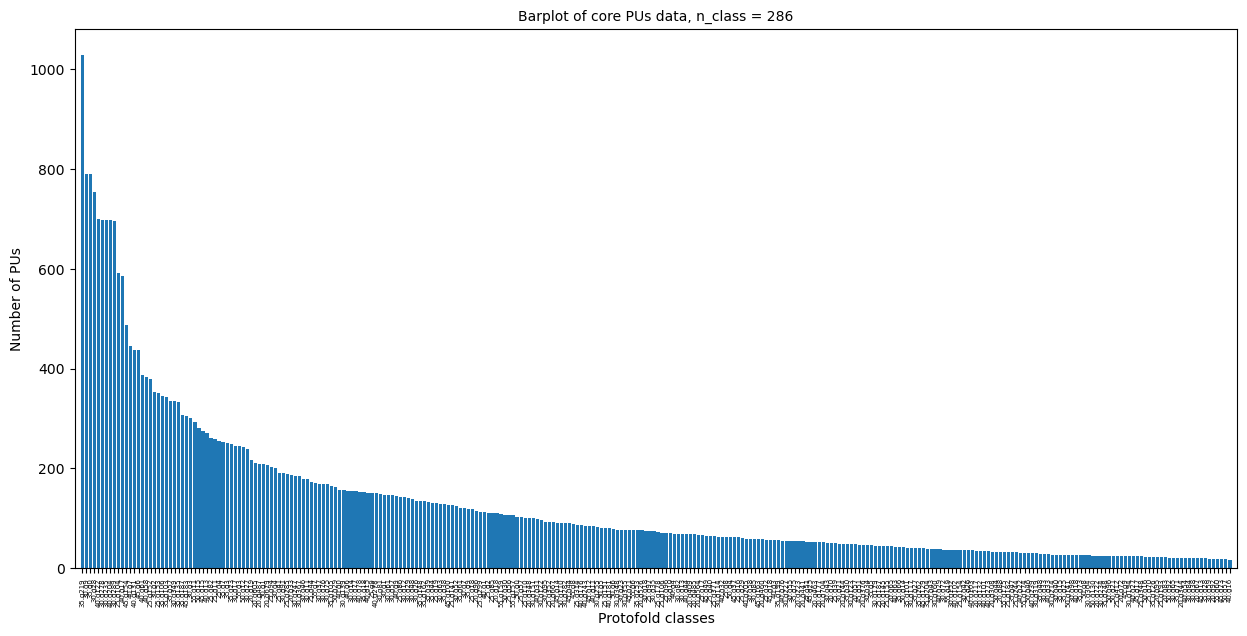

In [27]:
pu = [key for key, value in sorted(data_count.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']
value = [value for key, value in sorted(data_count.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']

plt.figure(figsize=(15,7))
plt.bar(range(len(data_count)-1), value, tick_label = pu)
plt.margins(x=0.005)
plt.yticks(size = 10)
plt.xticks(size = 5, rotation = 90)
plt.xlabel("Protofold classes", size = 10)
plt.ylabel("Number of PUs", size = 10)
plt.title(f"Barplot of core PUs data, n_class = {len(data_count.keys())-1}", size = 10)
plt.show()

Because the discrepancy between groups is high, classes will be merged according to protofold ID (35.g219 will be merged with all "g219" classes) and ID with less than 200 samples will be excluded

In [28]:
tmp_merge = {}
for key, value in data_count.items():
    try:
        prefix, suffix = key.split('.')
        if suffix in tmp_merge:
            tmp_merge[suffix] += value
        else:
            tmp_merge[suffix] = value
    except:
        tmp_merge[key] = value

df_merge = pd.DataFrame.from_dict(tmp_merge, orient="index")
df_merge = df_merge[df_merge >= 200]
df_merge = df_merge.dropna()
merged_data = df_merge.to_dict()[0]

train_data = [x for x in train_data if x.split('/')[-2].split(".")[-1] in merged_data.keys()]
test_data = [x for x in test_data if x.split('/')[-2].split(".")[-1] in merged_data.keys()]
val_data = [x for x in val_data if x.split('/')[-2].split(".")[-1] in merged_data.keys()]

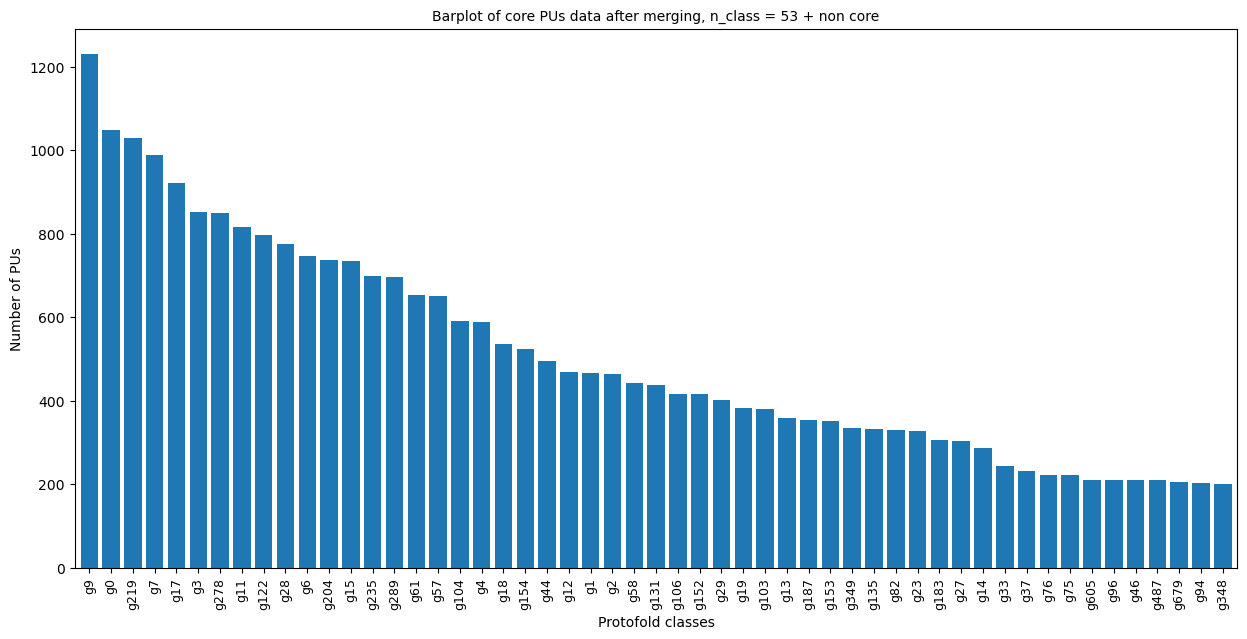

In [30]:
# One hot encoding of merged data
class_encoding = {}
for i, (key, value) in enumerate(merged_data.items()):
    class_encoding[key] = i

pu = [key for key, _ in sorted(merged_data.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']
value = [value for key, value in sorted(merged_data.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']

plt.figure(figsize=(15,7))
plt.bar(range(len(merged_data)-1), value, tick_label = pu)
plt.margins(x=0.005)
plt.yticks(size = 10)
plt.xticks(size = 9, rotation = 90)
plt.xlabel("Protofold classes", size = 10)
plt.ylabel("Number of PUs", size = 10)
plt.title(f"Barplot of core PUs data after merging, n_class = {len(merged_data.keys())-1} + non core", size = 10)
plt.show()

### Adjust weight

Adjust class weight base of classification used :

In [ ]:
sorted(data_count.items(), key=lambda x: x[1], reverse=True)

Class with highest number of samples except for non core is '35.g219'. This class will then be compared to order class and its weight will be adjusted according to length of dataset. For this classification, "noncore" will not be used because of the high number of samples in its class

Weight of class 35.g219 is : 23.55
Weight of other class is : 0.68


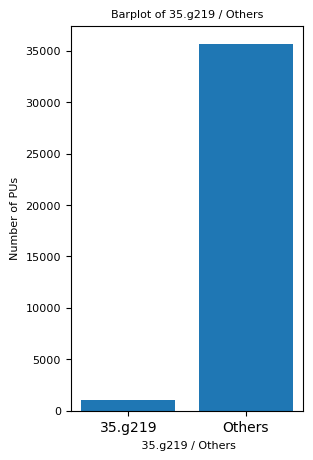

In [10]:
# For binary classification, we specify the class to compare

class_classif = '35.g219'
weight_classif = round(len(train_data)/data_count[class_classif], 2)
sum_nonclassif = sum(value for key, value in data_count.items() if key not in [class_classif, "noncore"])
weight_nonclassif = round(len(train_data)/sum_nonclassif, 2)
class_weights = {0 : weight_nonclassif, 1 : weight_classif}
print(f"Weight of class {class_classif} is : {weight_classif}\nWeight of other class is : {weight_nonclassif}")

binary_key = [class_classif, 'Others']
binary_value = [data_count[class_classif], sum_nonclassif]

plt.figure(figsize=(3, 5))
plt.bar(binary_key, binary_value, tick_label = binary_key)
plt.yticks(size = 8)
plt.xlabel(f" {class_classif} / Others", size = 8)
plt.ylabel("Number of PUs", size = 8)
plt.title(f"Barplot of {class_classif} / Others", size = 8)
plt.show()

## Adjusted data (50 highest sample number)

In [3]:
nc_path = '/home/arnaud/projet_long/dataset/noncore'
tmp_list = [f"noncore/{data}" for data in os.listdir(nc_path)]
random.shuffle(tmp_list)
nc_list = tmp_list[:12000]

In [90]:
import shutil

for core in trim_data.keys():
    if core == "noncore":
        if not os.path.exists(f"/home/arnaud/projet_long/dataset/gelly/noncore"):
            os.makedirs(f"/home/arnaud/projet_long/dataset/gelly/noncore")
        for element in tqdm(nc_list):
            path_source = f"./{element}"
            path_target = f"/home/arnaud/projet_long/dataset/gelly/{element}"
            shutil.copy(path_source, path_target)
            
    else:
        # list_path = os.listdir(f"/home/arnaud/projet_long/dataset/core/{core}")
        # for element in list_path:
        #     path_source = f"./core/{core}/{element}"
        #     path_target = f"./gelly/{core}/{element}"
    
        #     if not os.path.exists(f"/home/arnaud/projet_long/dataset/gelly/{core}"):
        #         os.makedirs(f"/home/arnaud/projet_long/dataset/gelly/{core}")
            
        #     shutil.copy(path_source, path_target)
        pass
    

100%|██████████| 12000/12000 [00:37<00:00, 316.44it/s]


In [11]:
trim_data = {}
train_trim_data, test_trim_data, val_trim_data = [], [], []
path = '/home/arnaud/projet_long/dataset/arnaud_data'
core_list = os.listdir(path)
split_coeff = .8
for core in core_list:
    trim_list = [f"arnaud_data/{core}/{data}" for data in os.listdir(os.path.join(path, core))]
    random.shuffle(trim_list)
    split_data(split_coeff, trim_list, train_trim_data, test_trim_data, val_trim_data)
    trim_data[core] = len(trim_list)

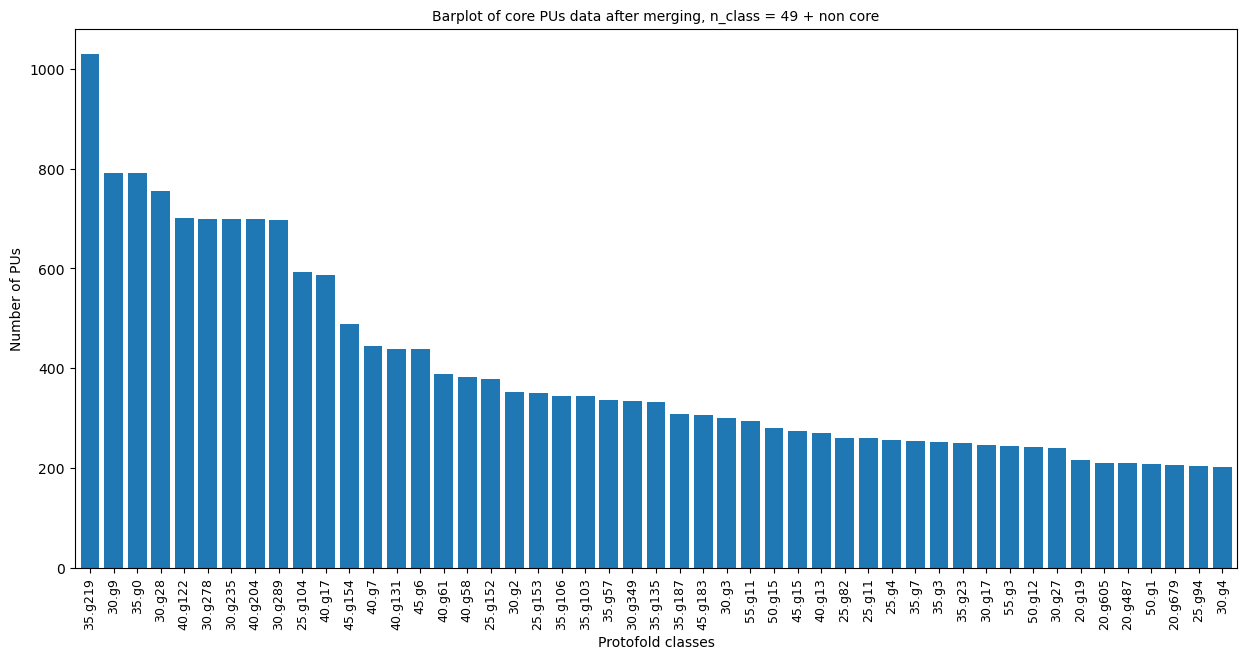

In [6]:
pu = [key for key, _ in sorted(trim_data.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']
value = [value for key, value in sorted(trim_data.items(), key=lambda x: x[1], reverse=True) if key != 'noncore']

plt.figure(figsize=(15,7))
plt.bar(range(len(trim_data)-1), value, tick_label = pu)
plt.margins(x=0.005)
plt.yticks(size = 10)
plt.xlabel("Protofold classes", size = 10)
plt.xticks(size = 9, rotation = 90)
plt.ylabel("Number of PUs", size = 10)
plt.title(f"Barplot of core PUs data after merging, n_class = {len(trim_data.keys())-1} + non core", size = 10)
plt.show()

In [7]:
a = len(train_trim_data) + len(test_trim_data) + len(val_trim_data)
print(f"After splitting data between train/test dataset :\nTrain dataset contains {len(train_trim_data)} PUs, {round(len(train_trim_data)*100/a)}% of total PUs\nTest dataset contains {len(test_trim_data)} PUs, {round(len(test_trim_data)*100/a)}% of total PUs\nVal dataset contains {len(val_trim_data)} PUs, {round(len(val_trim_data)*100/a)}% of total PUs")

After splitting data between train/test dataset :
Train dataset contains 20053 PUs, 64% of total PUs
Test dataset contains 6298 PUs, 20% of total PUs
Val dataset contains 5036 PUs, 16% of total PUs


Weight of class noncore is : 1.67
Weight of other class is : 1.03
12000
19387


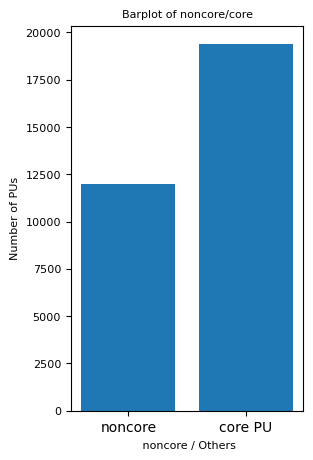

In [94]:
class_classif = 'noncore'
weight_classif = round(len(train_trim_data)/trim_data[class_classif], 2)
sum_nonclassif = sum(value for key, value in trim_data.items() if key != "noncore")
weight_nonclassif = round(len(train_trim_data)/sum_nonclassif, 2)
class_weights = {0 : weight_classif, 1 : weight_nonclassif}
print(f"Weight of class {class_classif} is : {weight_classif}\nWeight of other class is : {weight_nonclassif}")
print(f"{trim_data[class_classif]}\n{sum_nonclassif}")

binary_key = [class_classif, 'core PU']
binary_value = [trim_data[class_classif], sum_nonclassif]

plt.figure(figsize=(3, 5))
plt.bar(binary_key, binary_value, tick_label = binary_key)
plt.yticks(size = 8)
plt.xlabel(f" {class_classif} / Others", size = 8)
plt.ylabel("Number of PUs", size = 8)
plt.title(f"Barplot of noncore/core", size = 8)
plt.show()

# Network application

For data : 
- data_count.keys() containing all protofold classes
- train_data and test_data containing list of files for the generator

In [15]:
for file in train_trim_data[:1]:
    data = pd.read_csv(file, header=None).values
    print(data.shape[0])

60


In [9]:
def data_generator(files, batch_size, num_classes, method, class_classification = None):
    num_files = len(files)
    
    while True:
        np.random.shuffle(files)
        for i in range(0, num_files, batch_size):
            batch_files = files[i:i+batch_size]
            batch_data = []
            batch_labels = []
            for file in batch_files:
                data = pd.read_csv(file, header=None).values
                label = file.split('/')[-2]
                if method == "binary":
                    if label == "noncore":
                        batch_labels.append(0)
                        batch_data.append(data)
                    else:
                        batch_labels.append(1)
                        batch_data.append(data)
                elif method == "categorical_merge":
                    merged_label = label.split('.')[-1]
                    batch_labels.append(class_encoding[merged_label])
                    batch_data.append(data)
                elif method == "categorical":
                    batch_labels.append(class_encoding[label])
                    batch_data.append(data)
                    
            batch_data = np.array(batch_data)
            if method == "binary":
                batch_labels = np.array(batch_labels)
                batch_labels = to_categorical(batch_labels, 2)
            else:
                batch_labels = np.array(batch_labels)
                batch_labels = to_categorical(batch_labels, num_classes)

            
            yield batch_data, batch_labels

In [16]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience = 5,
    mode = 'min',
    verbose = 1)

## Binary

In [126]:
#For binary classification

batch_size = 64
num_classes = 2

random.shuffle(train_trim_data)
random.shuffle(val_trim_data)
random.shuffle(test_trim_data)
train_bin_generator = data_generator(train_trim_data, batch_size, num_classes, method = "binary", class_classification = class_classif)
val_bin_generator = data_generator(val_trim_data, batch_size, num_classes, method = "binary", class_classification = class_classif)
test_bin_generator = data_generator(test_trim_data, batch_size, num_classes, method = "binary", class_classification = class_classif)

In [7]:
#For binary classification

batch_size = 64
num_classes = 2
class_classif = "noncore"
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)
train_bin_generator = data_generator(train_data, batch_size, num_classes, method = "binary", class_classification = class_classif)
val_bin_generator = data_generator(val_data, batch_size, num_classes, method = "binary", class_classification = class_classif)
test_bin_generator = data_generator(test_data, batch_size, num_classes, method = "binary", class_classification = class_classif)

In [17]:
def gru_binary(learn_rate):
    model = Sequential()
    model.add(GRU(64, input_shape=(60, 1280), return_sequences=True))
    model.add(GRU(64))
    model.add(Dense(1, activation='softmax'))

    # optimizer = Adam(learning_rate=learn_rate)
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


learn_rate = 1e-4
model = gru_binary(learn_rate)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 64)            258432    
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 283,457
Trainable params: 283,457
Non-trainable params: 0
_________________________________________________________________


2023-05-31 23:06:14.861963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 23:06:14.863062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 23:06:14.864461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
steps_per_epoch = len(train_data) // batch_size
val_bin_steps = len(val_data) // batch_size

output_file = f"./save/bin_adjusted_batch{batch_size}_lr{str(learn_rate).split('e')[-1]}.csv"
csv_logger = tf.keras.callbacks.CSVLogger(output_file)

hist_model = model.fit(
    train_bin_generator, 
    validation_data = val_bin_generator, 
    steps_per_epoch = steps_per_epoch, 
    validation_steps = val_bin_steps, 
    epochs = 2, 
    # class_weight = class_weights,
    callbacks = [early_stopping_callback, csv_logger]
    )

Epoch 1/2


2023-05-31 23:04:03.436657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-31 23:04:03.544563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 23:04:03.545797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

3/3 [==============================] - 38s 14s/step - loss: 0.6932 - accuracy: 0.5000
Epoch 2/2


2023-05-31 23:04:41.528686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 41s 13s/step - loss: 0.6932 - accuracy: 0.5000


In [105]:
steps_per_epoch = len(train_trim_data) // batch_size
val_bin_steps = len(val_trim_data) // batch_size

output_file = f"./save/bin_adjusted_batch{batch_size}_lr{str(learn_rate).split('e')[-1]}.csv"
csv_logger = tf.keras.callbacks.CSVLogger(output_file)

cat_model = gru_bin_model.fit(
    train_bin_generator, 
    validation_data = val_bin_generator, 
    steps_per_epoch = steps_per_epoch, 
    validation_steps = val_bin_steps, 
    epochs = 40, 
    # class_weight = class_weights,
    callbacks = [early_stopping_callback, csv_logger]
    )

Epoch 1/40


2023-05-31 21:34:00.989022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 42/313 [===>..........................] - ETA: 1:35:59 - loss: 0.6932 - accuracy: 0.5000

KeyboardInterrupt: 

## Catego

In [8]:
# For categorical classification

batch_size = 128
num_classes = len(merged_data.keys())

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)
train_cat_generator = data_generator(train_data, batch_size, num_classes, method = "categorical_merge")
val_cat_generator = data_generator(val_data, batch_size, num_classes, method = "categorical_merge")
test_cat_generator = data_generator(test_data, batch_size, num_classes, method = "categorical_merge")

In [9]:
def gru_catego():
    model = Sequential()
    model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(60, 1280)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(32)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation="sigmoid"))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
gru_cat_sigmoid_model = gru_catego()
gru_cat_sigmoid_model.summary()

2023-05-29 22:36:29.123699: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-05-29 22:36:29.287829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 22:36:29.288693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-29 22:36:29.2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 60, 128)          516864    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 54)                3510      
                                                                 
Total params: 555,638
Trainable params: 555,638
Non-trai

2023-05-29 22:36:29.617878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-29 22:36:29.640369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-29 22:36:29.641179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

In [ ]:


steps_per_epoch = len(train_data) // batch_size
val_steps = len(val_data) // batch_size
cat_model = gru_cat_sigmoid_model.fit(
    train_cat_generator, 
    validation_data = val_cat_generator, 
    steps_per_epoch = steps_per_epoch, 
    validation_steps = val_steps, 
    epochs = 40, 
    # class_weight = class_weights,
    callbacks = [early_stopping_callback]
    )

In [37]:
steps_test = len(test_data) // batch_size

gru_cat_model.evaluate(test_cat_generator, steps=steps_test)

2023-05-29 16:14:54.611338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 227s 8s/step - loss: 2.6041 - accuracy: 0.2372


[2.6041111946105957, 0.23723958432674408]

In [32]:
gru_cat_model.save('./save/cat_gru_merge_model.h5')

In [12]:
train_loss = hist_model.history['loss']
val_loss = hist_model.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyError: 'val_loss'

[2.6041111946105957, 0.23723958432674408] Evaluation for GRU categorical with merged data, after 16 epochs, with early stopping